In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import nltk
import pandas as pd
import keras
import numpy as np
from gensim.models import KeyedVectors
from collections import Counter
import multiprocessing
from nltk.corpus import stopwords
from string import punctuation
import multiprocessing
from gensim.models import Word2Vec

import collections
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Importing utility functions from Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Input, InputLayer

import pickle



In [58]:
with open('tokenized_df.pickle', 'rb') as handle:
    data = pickle.load(handle)

data["label"] = data["label"].astype('int')
data["label"].value_counts()


 1    97764
 0    80800
-1    52568
Name: label, dtype: int64

<AxesSubplot: ylabel='Frequency'>

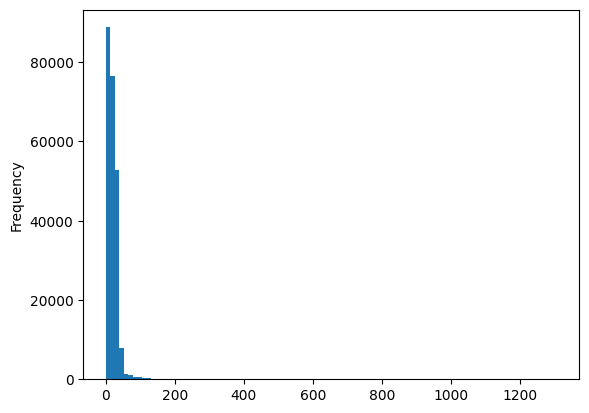

In [59]:
data["tokens"].apply(lambda x: len(x)).plot(kind='hist', bins=100)

In [60]:
from gensim.models import keyedvectors,KeyedVectors

embeddings = KeyedVectors.load_word2vec_format('embeddings_unks_25.txt', binary=False)


In [61]:
from time import time_ns
from keras.preprocessing.text import Tokenizer

def read_embeddings(embeddings: KeyedVectors,tokenizer: Tokenizer) -> tuple[dict[str,list], dict[int,list]]:
    '''Loads and parses embeddings trained in earlier.
    Parameters and return values are up to you.
    '''
    embeddings_size = len(embeddings[embeddings.index_to_key[0]])
    # str : array mapping
    word_embeddings = {w:embeddings[w] for w in tokenizer.word_index } # TODO: mmake compatible with pre-made embeddings
    # int : array mapping
    encoded_embeddings = {tokenizer.word_index[w]:word_embeddings[w] for w in word_embeddings}
    encoded_embeddings[0] = np.zeros(embeddings_size)
    return word_embeddings, encoded_embeddings

def get_X_and_y(data : pd.DataFrame, tokenizer: Tokenizer, enc_embed:dict):
    '''Returns X and y from the data.
    '''
    # convert text to sequences

    # pad sequences to length 50
    padded_seqs = pad_sequences(tokenizer.texts_to_sequences(data["tokens"]), maxlen=50, padding='post')
    # X =  np.array([[weight for token in seq for weight in enc_embed[token]] for seq in padded_seqs])
    y = to_categorical(data["label"].values+1)
    return padded_seqs,y

def get_bow_and_labels(data : pd.DataFrame, tokenizer: Tokenizer):
    '''Returns X and y from the data.
    '''
    # convert text to sequences
    # feature_vocab = [word for word, count in counter.most_common(100)]

    X = tokenizer.texts_to_matrix(data["tokens"], mode='count')
    y = to_categorical(data["label"].values+1)
    return X,y

# def data_generator(X, y, batch_size: int, tokenizer: Tokenizer, enc_embed:dict) -> tuple[list,list]:
#     '''
#     Returns data generator to be used by feed_forward
#     https://wiki.python.org/moin/Generators
#     https://realpython.com/introduction-to-python-generators/
    
#     Yields batches of embeddings and labels to go with them.
#     Use one hot vectors to encode the labels 
#     (see the to_categorical function)
    
#     '''
#     i = 0
#     for i in range(0,len(y),batch_size):
#         next_i = min(len(y), i+batch_size)
#         # for each sequence in the batch, flatten all word embedding vectors into one vector
#         embeddings = np.array([np.array([weight for word_index in sequence for weight in enc_embed[word_index]]) for sequence in X[i:next_i]])
#         # generate categorical data
#         labels = to_categorical(y[i:next_i]-1,num_classes=len(tokenizer.word_counts))
#         yield embeddings, labels


def data_generator(padded_seqs, y, batch_size: int, enc_embed) -> tuple[list,list]:
    '''
    Returns data generator to be used by feed_forward
    https://wiki.python.org/moin/Generators
    https://realpython.com/introduction-to-python-generators/
    
    Yields batches of embeddings and labels to go with them.
    Use one hot vectors to encode the labels 
    (see the to_categorical function)
    
    '''
    while True:
        i = 0
        for i in range(0,len(y),batch_size):
            next_i = min(len(y), i+batch_size)
            # for each sequence in the batch, flatten all word embedding vectors into one vector
            X_batch = padded_seqs[i:next_i]
            embeddings =  np.array([[weight for token in seq for weight in enc_embed[token]] for seq in X_batch])

            # generate categorical data
            labels = y[i:next_i]
            yield embeddings, labels

def bow_generator(X, y, batch_size: int, enc_embed) -> tuple[list,list]:
    '''
    Returns data generator to be used by feed_forward
    https://wiki.python.org/moin/Generators
    https://realpython.com/introduction-to-python-generators/
    
    Yields batches of embeddings and labels to go with them.
    Use one hot vectors to encode the labels 
    (see the to_categorical function)
    
    '''
    while True:
        i = 0
        for i in range(0,len(y),batch_size):
            next_i = min(len(y), i+batch_size)
            # for each sequence in the batch, flatten all word embedding vectors into one vector
            X_batch = X[i:next_i]
            embeddings =  np.array([[weight for token in bows for weight in enc_embed[token]] for bows in X_batch])

            # generate categorical data
            labels = y[i:next_i]
            yield embeddings, labels

In [62]:
from collections import Counter
## SPLIT DATA ##

tokenizer = Tokenizer(num_words=100, oov_token="UNK")
tokenizer.fit_on_texts(data["tokens"])
word_counter = Counter([token for line in data["tokens"] for token in line])
print(len(word_counter))
word_counter.most_common(100)




# select 10% of rows from data dataframe
small_data = data.sample(frac=0.10, random_state=69)


word_embed, enc_embed = read_embeddings(embeddings, tokenizer)
# X,y = get_X_and_y(small_data,tokenizer, enc_embed)
# X_train, X_test, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=69)

# print(X_test)
# print(X_test.shape)
# print(len(X_test))

X,y = get_bow_and_labels(small_data, tokenizer)
print(X.shape)
print(X[0])


56994
(23113, 100)
[0. 5. 2. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [63]:
# given lines of text (arraylike) and embeddings (model.wv)
def train_model(X, y,embeddings:KeyedVectors, tokenizer: Tokenizer, enc_embed:dict,epochs=100, x_val=None, y_val=None):
   

    # print("X:",X)
    # print("y:",y)

    # get word embeddings dictionaries for our corpus
    

    embeddings_size = len(enc_embed[1])
    batch_size = 32
    data_gen = data_generator(X, y, batch_size=batch_size, enc_embed=enc_embed)
    data_gen_val = data_generator(x_val, y_val, batch_size=batch_size, enc_embed=enc_embed)
    sample = next(data_gen)
    # print(sample.shape)

    # Define the model architecture using Keras Sequential API
    model = Sequential()
    model.add(layer_h0 := Dense(500, input_shape=(len(sample[0][0]),))) 
    model.add(layer_h1 := Dense(250, activation='relu'))
    model.add(layer_h1 := Dense(100, activation='relu'))
    model.add(layer_h1 := Dense(50, activation='relu'))
    model.add(layer_o := Dense(len(y[0]),activation="softmax")) 

    # setup model for learning
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    
    # train the model
    history = model.fit(data_gen, epochs=epochs, steps_per_epoch=len(X)//32, verbose=1, 
                        validation_steps=len(x_val)//32, validation_data=data_gen_val)

    # return the model, tokenizer, and embedding dict for sentence generation use later
    return model,tokenizer,history



In [66]:
from collections import Counter
import os

tokenizer = Tokenizer(num_words=1000, oov_token="UNK")
tokenizer.fit_on_texts(data["tokens"])
# word_counter = Counter([token for line in data["tokens"] for token in line])
# print(len(word_counter))

epochs = 10

small_data = data.sample(frac=0.2, random_state=69)

for embbeddings_size in [25]: #,50,100,200]:
    if os.path.exists(f'ffnn{embbeddings_size}_{epochs}_epochs.pickle'):
        print("ffnn already trained for this embedding size")
        continue
    embeddings = KeyedVectors.load_word2vec_format(f'embeddings_unks_{embbeddings_size}.txt', binary=False)
    word_embed, enc_embed = read_embeddings(embeddings, tokenizer)
    X,y = get_bow_and_labels(small_data,tokenizer)
    X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y, test_size=0.5, random_state=69)
    X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
    net, tok, history = train_model(X_train, y_train,embeddings,tokenizer, enc_embed, epochs=epochs, x_val=X_val, y_val=y_val)
    with open(f'ffnn{embbeddings_size}.pickle', 'wb') as handle:
        pickle.dump(net, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(net.evaluate(data_generator(X_test, y_test, batch_size=32, enc_embed=enc_embed), steps=len(X_test)//32))
    

# word_embed, enc_embed = read_embeddings(embeddings, tokenizer)
# X,y = get_X_and_y(small_data,tokenizer, enc_embed)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)


# net2, tok2 = train_model(X_train, y_train,embeddings,tokenizer, enc_embed, epochs=100)
# with open('ffnn200.pickle', 'wb') as handle:
#     pickle.dump(net2, handle, protocol=pickle.HIGHEST_PROTOCOL)


Epoch 1/10
722/722 [==============================] - 215s 297ms/step - loss: 0.7178 - accuracy: 0.7071 - val_loss: 0.5458 - val_accuracy: 0.7952
Epoch 2/10
722/722 [==============================] - 219s 303ms/step - loss: 0.5578 - accuracy: 0.7840 - val_loss: 0.4923 - val_accuracy: 0.8096
Epoch 3/10
722/722 [==============================] - 219s 303ms/step - loss: 0.4921 - accuracy: 0.8013 - val_loss: 0.4886 - val_accuracy: 0.8086
Epoch 4/10
722/722 [==============================] - 212s 293ms/step - loss: 0.4381 - accuracy: 0.8214 - val_loss: 0.4545 - val_accuracy: 0.8205
Epoch 5/10
722/722 [==============================] - 203s 281ms/step - loss: 0.3975 - accuracy: 0.8378 - val_loss: 0.4126 - val_accuracy: 0.8365
Epoch 6/10
722/722 [==============================] - 204s 283ms/step - loss: 0.3483 - accuracy: 0.8596 - val_loss: 0.3722 - val_accuracy: 0.8512
Epoch 7/10
722/722 [==============================] - 205s 284ms/step - loss: 0.3003 - accuracy: 0.8770 - val_loss: 0.3604 -

In [ ]:


for embbeddings_size in [25,50,100]:#,200]:
    if not os.path.exists(f'ffnn{embbeddings_size}.pickle'):
        print("model hasnt been trained yet")
        continue
    embeddings = KeyedVectors.load_word2vec_format(f'embeddings_unks_{embbeddings_size}.txt', binary=False)
    word_embed, enc_embed = read_embeddings(embeddings, tokenizer)
    X,y = get_X_and_y(small_data,tokenizer, enc_embed)
    X_train, X_test, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69)
    # load net from pickle file 
    print(embbeddings_size)
    with open(f'ffnn{embbeddings_size}.pickle', 'rb') as handle:
        net : Sequential = pickle.load(handle)

    print(net.predict(data_generator(X_test, y_val, batch_size=32, enc_embed=enc_embed), steps=len(X_test)//32))
    # print(net.evaluate(data_generator(X_test, y_test, batch_size=32, enc_embed=enc_embed), steps=len(X_test)//32))

25
Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-04-16 15:34:12     22705992
metadata.json                                  2023-04-16 15:34:12           64
config.json                                    2023-04-16 15:34:12         2701
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
........

In [ ]:
print(y_val)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]
